In [27]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import colors
from photutils import EllipticalAnnulus
import marvin
from marvin.tools.maps import Maps
from marvin.utils.general.images import showImage
import marvin.utils.plot.map as mapplot
from VW_PCA import VW_PCA

In [11]:
from marvin import config

# by default the mode is set to 'auto', but let's set it explicitly to local/remote.
config.mode = 'auto'
config.download = True

dir = '/data/kate/MaNGA/'
fig_dir = dir+'FIGS/'

In [12]:
cat = fits.open(dir+'DATA/drpall-v2_0_1_gals.fits')
tbdata = cat[1].data
cat.close()

#Remove bad IFUs with critical flags
DRP3QUAL = tbdata.field('DRP3QUAL')
ind_good = np.where((DRP3QUAL < 300)) #2779 -> 2742

plateifu = tbdata.field('plateifu')[ind_good]
z = tbdata.field('nsa_z')[ind_good]
petro_r_50 = tbdata.field('nsa_elpetro_th50_r')[ind_good]
nsa_elpetro_ba = tbdata.field('nsa_elpetro_ba')[ind_good]
nsa_elpetro_mass = tbdata.field('nsa_elpetro_mass')[ind_good]
nsa_elpetro_phi = tbdata.field('nsa_elpetro_phi')[ind_good]

## Plot PCA classes (preclassified)

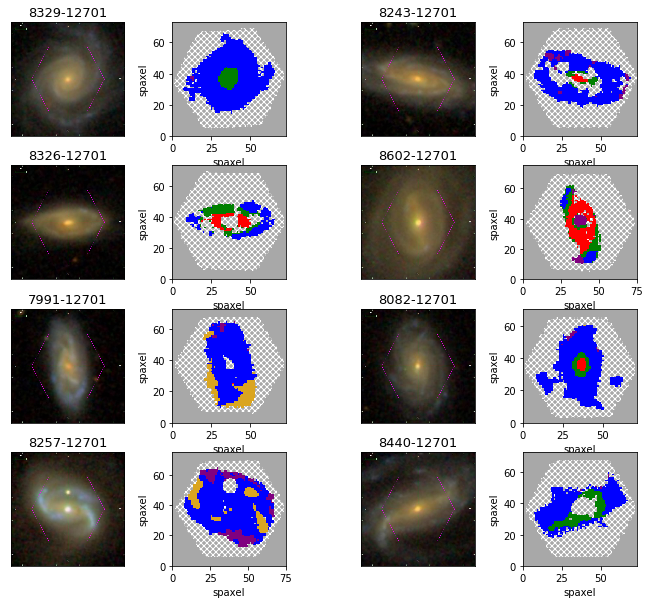

In [39]:
select = np.where( (nsa_elpetro_mass > 1E10) & (nsa_elpetro_mass < 1E12) & (nsa_elpetro_ba>0.35) & \
                     (z < 0.05) & (petro_r_50 > 5.) & \
                     (plateifu != '8140-12701') & (plateifu != '8550-12701') )

n_select = 4

# make a color map of fixed colors
cmap = colors.ListedColormap([ 'red', 'blue', 'goldenrod', 'green', 'purple'])
bounds=[1,2,3,4,5,6]
norm = colors.BoundaryNorm(bounds, cmap.N)

cols=4

fig, axs = plt.subplots(nrows=n_select, ncols=cols, figsize=(3*cols, 2.5*n_select))
fig.subplots_adjust(hspace=0.26, wspace=.22)

for i in range(n_select):
    for j in range(2):

        ind = select[0][(2*i+j)]
        
        #Plot SDSS image
        image = showImage(plateifu=plateifu[ind], show_image=False)
        img = axs[i, j*2].imshow(image)
        axs[i, j*2].set_title(str(plateifu[ind]), fontsize=13)
        axs[i, j*2].get_xaxis().set_visible(False) #Suppress tick labels
        axs[i, j*2].get_yaxis().set_visible(False)

        #Plot PCA class map
        hdu = fits.open('/data/kate/MaNGA/PCA_results/manga-'+plateifu[ind]+'_PCA.fits.gz')
        sfh_class = hdu['classmap'].data.T
        sfh_class = np.ma.MaskedArray(sfh_class, mask=sfh_class < 0) #Mask junk

        #Apply quality mask
        PCA_SNR_masked = np.ma.MaskedArray(sfh_class, mask=hdu['qualmask'].data == 1)
             
        #Define no coverage (edge of IFU) from Halpha map (can use any map).
        maps = Maps(plateifu=plateifu[ind])
        ha = maps['emline_gflux_ha_6564']
        nocov = mapplot.no_coverage_mask(mask=ha.mask, bit=0, ivar=ha.ivar)
        
        #Bad data from qualmask
        bad_data = np.ma.getmaskarray(PCA_SNR_masked) * 2**30
        
        #Combine with coverage mask
        mask = nocov | bad_data
        
        fig, ax, cb = mapplot.plot(value=PCA_SNR_masked, mask=mask, \
                     cmap=cmap, fig=fig, ax=axs[i, (j*2)+1], cbrange=(1,5), return_cb=True)
        cb.remove() #Remove colour bar

plt.savefig(fig_dir+'Example_PCA2.pdf', bbox_inches='tight')
plt.show()

# Classify spaxels based on PC1 PC2 values (in case you want to change the classification boundaries)

In [29]:
vwPca = VW_PCA()

vertices_lowmass = {
"psb_cut":0.4, \
"sb_vert1":-2.3, \
"sb_vert2":-5.7, \
"sb_vert3":-6.2, \
"sf_vert1":-5.8, \
"sf_vert2":-5.5, \
"sf_vert3":-2., \
"sf_vert4":-3., \
"green_vert1": -0.35, \
"green_vert2": -2.1, \
"red_vert1": 1.5, \
"red_vert2": 1.3, \
"junk_y_lower": -1.2, \
"junk_y_lower2": -3., \
"junk_y_upper": 2., \
"left_cut": -7.1, \
"right_cut": 2., \
}

vertices_highmass = {
"psb_cut":0.4, \
"sb_vert1":-2.3, \
"sb_vert2":-5.2, \
"sb_vert3":-5.8, \
"sf_vert1":-5.3, \
"sf_vert2":-5.0, \
"sf_vert3":-2., \
"sf_vert4":-3., \
"green_vert1": -0.35, \
"green_vert2": -2.1, \
"red_vert1": 1.5, \
"red_vert2": 1.3, \
"junk_y_lower": -1.2, \
"junk_y_lower2": -3., \
"junk_y_upper": 2., \
"left_cut": -7.1, \
"right_cut": 2., \
}

# make a color map of fixed colors
cmap = colors.ListedColormap([ 'red', 'blue', 'goldenrod', 'green', 'purple'])
bounds=[1,2,3,4,5,6]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i in range(10):

    hdu = fits.open('/data/kate/MaNGA/PCA_results/manga-'+plateifu[ind]+'_PCA.fits.gz')
    pc1 = hdu['PC1'].data
    pc2 = hdu['PC2'].data
    
    #PCA classification of spaxels
    points = np.stack((pc1.flatten(), pc2.flatten()), axis=1) #Needs to be a (ngal, 2) array

    #Classification boundaries depend on stellar mass
    if nsa_elpetro_mass[i] < 1E10:
        class_map = vwPca.PCA_classify(points, vertices_lowmass)
    elif nsa_elpetro_mass[i] >= 1E10:
        class_map = vwPca.PCA_classify(points, vertices_highmass)

    class_map_reshaped = class_map.reshape(pc1.shape[0], pc1.shape[1])


# Count spaxels in an annulus/aperture

In [52]:
#Setting up aperture

ind = select[0][0]
print plateifu[ind]

hdu = fits.open('/data/kate/MaNGA/PCA_results/manga-'+plateifu[ind]+'_PCA.fits.gz')

x = hdu[1].data.shape[0]/2
y = hdu[1].data.shape[1]/2

spaxel_size = 0.5 # "/pix pixel scale

#Convert from arcsec to pixels
ellip_ap_radius_pix_in_major = ( petro_r_50[ind] / 2. ) / spaxel_size
ellip_ap_radius_pix_out_major = ( (petro_r_50[ind] / 2.) + 5.  ) / spaxel_size
ellip_ap_radius_pix_out_minor = nsa_elpetro_ba[ind] * ellip_ap_radius_pix_out_major

#The rotation angle in radians of the semimajor axis from the
#positive x axis. The rotation angle increases counterclockwise.
#nsa_elpetro_phi is Angle (E of N) - needs -90 to make the right way up.
theta = np.radians(nsa_elpetro_phi[ind]-90.)

8329-12701


In [53]:
#Function to return an elliptical annulus/aperture mask
def getAperture(x, y, ellip_ap_radius_pix_in_major, ellip_ap_radius_pix_out_major, ellip_ap_radius_pix_out_minor, \
                theta):

    ellipical_annuli = EllipticalAnnulus([x, y], ellip_ap_radius_pix_in_major, ellip_ap_radius_pix_out_major, \
                                         ellip_ap_radius_pix_out_minor, theta) #In pixels
    masks_ellipical = ellipical_annuli.to_mask(method='exact')
    mask_ellipical = masks_ellipical[0] #Because masks is a list (even if it has one element)
            
    return mask_ellipical

In [54]:
#Get elliptical annulus/aperture mask
mask_ellipical = getAperture(x, y, ellip_ap_radius_pix_in_major, ellip_ap_radius_pix_out_major, \
                             ellip_ap_radius_pix_out_minor, theta)

In [55]:
hdu = fits.open('/data/kate/MaNGA/PCA_results/manga-'+plateifu[ind]+'_PCA.fits.gz')
sfh_class = hdu['classmap'].data.T
sfh_class = np.ma.MaskedArray(sfh_class, mask=sfh_class < 0) #Mask junk

#Apply quality mask
PCA_SNR_masked = np.ma.MaskedArray(sfh_class, mask=hdu['qualmask'].data == 1)

#Apply spx mask so spaxels don't get double counted
PCA_spx_SNR_masked = np.ma.MaskedArray(PCA_SNR_masked, mask=hdu['spx_bin_mask'].data < 1)

#Apply mask to a map
PCA_cutout = mask_ellipical.cutout(PCA_spx_SNR_masked)

In [64]:
#If not all masked, print total number of spaxels in each PCA class in the annulus
if (PCA_cutout.mask.all() == False):
    total_spaxels_ell = np.ma.sum( mask_ellipical.data[np.ma.where(PCA_cutout > 0)])
    red_spaxels_ell = np.ma.sum( mask_ellipical.data[np.ma.where(PCA_cutout == 1)])
    blue_spaxels_ell = np.ma.sum( mask_ellipical.data[np.ma.where(PCA_cutout == 2)])
    sb_spaxels_ell = np.ma.sum( mask_ellipical.data[np.ma.where(PCA_cutout == 3)])
    green_spaxels_ell = np.ma.sum( mask_ellipical.data[np.ma.where(PCA_cutout == 4)])
    psb_spaxels_ell = np.ma.sum( mask_ellipical.data[np.ma.where(PCA_cutout == 5)])

print total_spaxels_ell, blue_spaxels_ell

frac_psb = psb_spaxels_ell / total_spaxels_ell
print frac_psb

827.889859696 827.889859696
0.0
